### Fitting Models for readmission vs non-readmission Dataset

In the previous notebook, the diabetes dataset was cleaned followed by recoding of features and EDA. The second aim of this project is to predict readmission(<30 days and >30 days) versus no readmission of diabetic patients in the US based on patient hospital records. This notebook addresses this aim. Classification models using machine learning will be built to predict readmission outcome of patients.

In [ ]:
# Try for 'readmitted_p' using the 'diabetes_3d_p.csv' dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
# Importing the relevant classes
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report

/Users/dakshi/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Load the required files
X_train = pd.read_csv('./Datasets/X_train.csv')
X_test = pd.read_csv('./Datasets/X_test.csv')
y_train = pd.read_csv('./Datasets/y_train.csv')
y_test = pd.read_csv('./Datasets/y_test.csv')
X_ros = pd.read_csv('./Datasets/X_ros.csv')
y_ros = pd.read_csv('./Datasets/y_ros.csv')

In [4]:
# Drop the 'Unnamed: 0' column
X_train.drop('Unnamed: 0', axis=1, inplace=True)
X_test.drop('Unnamed: 0', axis=1, inplace=True)
y_train.drop('Unnamed: 0', axis=1, inplace=True)
y_test.drop('Unnamed: 0', axis=1, inplace=True)
X_ros.drop('Unnamed: 0', axis=1, inplace=True)
y_ros.drop('Unnamed: 0', axis=1, inplace=True)

This is a binary classification problem and hence different classifiers will be fit to the training set and the classifier that gives the best metrics will be chosen to score the test set and make predictions. The metric that will be used to decide the best classifer will be the precision, recall, f1 and average precision scores. Specifically, a higher average_precision score will indicate a better preformance of the classifier.

In [57]:
# Defining a function to return the precision, recall, f1 and average precision score
# Defining functions to plot Precision-Recall Curve--. 

from sklearn.metrics import precision_recall_fscore_support, average_precision_score, precision_recall_curve, auc

def scores(y_test, y_pred):
    
    '''
    Function takes in y_test, y_predict y_predict probability and scores to return precision, recall, f1 and
    average_precision  scores of the positive class
    '''
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, beta=1.0)
    average_precision = average_precision_score(y_test, y_pred)
    return precision[1], recall[1], f1[1], average_precision

def precision_recall(y_test, y_pred, y_pred_proba, classifier):
    
    '''
    Function accepts the y_test scores and y_predict probability scores to plot the precison-recall curve
    '''
    
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='g', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='g')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall for ' +classifier+ ' Classifier : AP={0:0.2f}'.format(average_precision))
    return plt

The classifiers used will be Logistic Regression, MLP(Multilayer Perceptron), XGBoost, RandomForest, Naive Bayes and StackingClassifier using Logistic, MLP, XGBoost and RandomForest as base classifiers and Logistic Regression as a Metaclassifier.

The dataset was previously split using stratified splitting into a training set and a test set, with 70% in the training set and 30% in the test set.

GridSearchCV will be used to fit training set with a given classifier and to tune the hyperparameters of the classifiers. Hyperparameter tuning will be optimised based on recall score. The classifier that gives the best recall score will be chosen to predict the test set.

The test set result and prediction accuracy will be checked using confusion matrix, classification report, and the precision-recall curve. A classifier that gives the highest area under the precision-recall curve of the positive class (class 0) will be chosen as the best classifier.

In [5]:
# First fit a Dummy Classifier to get a baseline of prediction on the test set
from sklearn.dummy import DummyClassifier
dm = DummyClassifier(strategy='stratified', random_state=12).fit(X_ros,y_ros['readmitted_p'])
y_pred0 = dm.predict(X_test)

In [6]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Fitting Logistic Regression
lr_params = {'penalty':['l1','l2'], 'solver':['liblinear'], 'C':list(np.arange(0.1, 5.1, 0.1)), 'random_state':[12]}
lr_gridsearch = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1, scoring='recall', n_jobs=-1)
lr_gridsearch.fit(X_ros,y_ros['readmitted_p'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [8]:
# Predicting the test set with the best LogisticRegression Classifier
#lr_best = lr_gridsearch.best_estimator_
lr_best = LogisticRegression(C=1.2000000000000002, penalty='l2', solver='liblinear', random_state=12).fit(X_ros,y_ros['readmitted_p'])
y_pred1 = lr_best.predict(X_test)

In [60]:
# Fitting MLP
mlp_params = {'activation' : ['logistic', 'identity'], 'solver' : ['sgd','lbfgs'], 'learning_rate_init':list(np.arange(0.001, 0.1, 0.01)), 'max_iter':[500], 'random_state':[12]}
mlp_gridsearch = GridSearchCV(MLPClassifier(), mlp_params, cv=5, verbose=1, scoring='recall', n_jobs=-1)
mlp_gridsearch.fit(X_ros,y_ros['readmitted_p'])

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 22.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'random_state': [12], 'activation': ['logistic', 'identity'], 'max_iter': [500], 'learning_rate_init': [0.001, 0.010999999999999999, 0.020999999999999998, 0.030999999999999996, 0.040999999999999995, 0.05099999999999999, 0.060999999999999992, 0.070999999999999994, 0.080999999999999989, 0.090999999999999984], 'solver': ['sgd', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

In [61]:
# The best hyperparamters that maximise recall score
mlp_gridsearch.best_params_

{'activation': 'logistic',
 'learning_rate_init': 0.001,
 'max_iter': 500,
 'random_state': 12,
 'solver': 'lbfgs'}

In [10]:
# Predicting the test set with the best MLP Classifier
#mlp_best = mlp_gridsearch.best_estimator_
mlp_best = MLPClassifier(activation='logistic', learning_rate_init=0.001, max_iter=500, random_state=12, solver='lbfgs').fit(X_ros,y_ros['readmitted_p'])
y_pred2 = mlp_best.predict(X_test)

In [11]:
print classification_report(y_test['readmitted_p'], y_pred2)

             precision    recall  f1-score   support

          0       0.64      0.61      0.63      2893
          1       0.45      0.49      0.47      1892

avg / total       0.57      0.56      0.56      4785



Even though Gridsearch returned a MLPClassifier with the best hyperparameters that maximise the recall score, the recall score of the positive class is very low. Based on other tuning done, another MLPClassifier with different hyperparamters that increases the recall score of the positive class was fit.

In [12]:
# Fitting another MLPClassifier to increase the recall score of the positive class
mlp2 = MLPClassifier(activation='identity', solver='lbfgs', random_state=12, max_iter=500).fit(X_ros, y_ros['readmitted_p'])
y_pred2b = mlp2.predict(X_test)

In [13]:
print classification_report(y_test['readmitted_p'], y_pred2b)

             precision    recall  f1-score   support

          0       0.70      0.63      0.66      2893
          1       0.51      0.58      0.54      1892

avg / total       0.62      0.61      0.62      4785



In [ ]:
# The recall score of the positive class has increased as compared to the classifier returned by GridSearchCV.

For tree based models such XGBoost Classifier, Random ForestClassifier, interaction terms should not be added into the model. The Naive Bayes theorem assumes independence between the features and hence interaction terms should not be added into the model. Hence, a new Dataframe of X variables(features) excluding the interaction terms was created for modeling. The interaction terms were also removed from the test set.

In [14]:
# Getting the list of interaction terms
non_interaction = [i for i in X_train.columns if '&' not in i]

In [15]:
# Create new X DataFrames that do not contain the interaction
X_train_n = X_train.loc[:, non_interaction]
X_test_n = X_test.loc[:, non_interaction]
X_ros_n = X_ros.loc[:, non_interaction]

In [ ]:
# Fitting XGBoost
xgb_params = {'max_depth':np.arange(3,8,1), 'n_estimators':[1000], 'colsample_bytree':np.arange(0.6,1.05,0.1), 'seed':[12]}
xgb_gridsearch = GridSearchCV(XGBClassifier(), xgb_params, cv=5, verbose=1, scoring='recall', n_jobs=-1)
xgb_gridsearch.fit(X_ros_n,y_ros['readmitted_p'])

Fitting 5 folds for each of 25 candidates, totalling 125 fits


The best parameters returned by XGBoost were:

{'colsample_bytree': 0.79999999999999993,
 'max_depth': 7,
 'n_estimators': 1000,
 'seed': 12}

In [18]:
xgb_best = XGBClassifier(colsample_bytree=0.79999999999999993, max_depth=7, n_estimators=1000, seed=12)
xgb_best.fit(X_ros_n,y_ros['readmitted_p'])
# Predicting the test set with the best MLP Classifier
y_pred3 = xgb_best.predict(X_test_n)

In [14]:
# Fitting RandomForest
rf_params = {'max_depth':np.arange(3,8,1), 'n_estimators':[1000], 'criterion':['entropy','gini'], 'max_features':np.arange(10,16,1),'random_state':[12]}
rf_gridsearch = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, verbose=1, scoring='recall', n_jobs=-1)
rf_gridsearch.fit(X_ros_n,y_ros['readmitted_p'])

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 29.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1000], 'max_features': array([10, 11, 12, 13, 14, 15]), 'random_state': [12], 'criterion': ['entropy', 'gini'], 'max_depth': array([3, 4, 5, 6, 7])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

In [15]:
# The best hyperparamters that maximise recall score
rf_gridsearch.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 14,
 'n_estimators': 1000,
 'random_state': 12}

In [19]:
# Predicting the test set with the best RandomForest Classifier
#rf_best = rf_gridsearch.best_estimator_
rf_best = RandomForestClassifier(criterion='gini', max_depth=7, max_features=14, n_estimators=1000, random_state=12).fit(X_ros_n,y_ros['readmitted_p'])
y_pred4 = rf_best.predict(X_test_n)

Next, Naive Bayes Classifier was used to fit the training set. GaussianNB Classifier was fit on the continuous features only while MultinomialNB Classifier was fit on the categorical features only. The predicted class probabilities of the test set from these 2 classifiers was obtained and the overall class membership of each patient was calculated based on the average of the 2 class probabilities.

In [20]:
#Defining the numerical and categorical features
num_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'number_outpatient', 'number_emergency', 'number_inpatient',]
cat_features = [i for i in X_ros_n.columns if i not in num_features]

In [21]:
# Subsetting out the numerical and categorical Dataframes in the training set
X_ros_num = X_ros_n.loc[:,num_features]
X_ros_cat = X_ros_n.loc[:,cat_features]
X_test_num = X_test_n.loc[:,num_features]
X_test_cat = X_test_n.loc[:,cat_features]

In [22]:
# Fit the GaussianNB model on numerical features and get predicted probs
gb_num = GaussianNB().fit(X_ros_num, y_ros['readmitted_p'])
gb_proba = gb_num.predict_proba(X_test_num)

In [23]:
# Fit the MultinomialNB model on categorical features and get predicted probs
mn_cat = MultinomialNB().fit(X_ros_cat, y_ros['readmitted_p'])
mn_proba = mn_cat.predict_proba(X_test_cat)

In [24]:
# Get Dataframe on these predicted probabilities from both numerical and categorical features
NB = pd.DataFrame(data = {'num_0':gb_proba[:,0], 'cat_0':mn_proba[:,0], 'num_1':gb_proba[:,1], 'cat_1':mn_proba[:,1]})
NB['class_0'] = NB[['num_0','cat_0']].sum(axis=1)/2
NB['class_1'] = NB[['num_1','cat_1']].sum(axis=1)/2

# 'y_label' refers to the overall class membership of the patient based on the average of the predicted probabilities of classifiers fit on just numerical or categorical data
NB['y_label'] = NB['class_1'].apply(lambda x: 1 if x>0.5 else 0)

A Stacking Classifier was used to fit the training data. A Stacking Classifier uses base estimators(classifiers) to fit the training data and make predictions on the test set. The predictions from each base estimator are then used as new features which are fit into a metaclassifier, and then used to get the final predictions on the test set.

In [25]:
# Stacking Classifier
lr = LogisticRegression(C=1.2000000000000002, penalty='l2', random_state=12, solver='liblinear')
mlp = MLPClassifier(activation='identity', solver='lbfgs', random_state=12, max_iter=500)
xgb = XGBClassifier(colsample_bytree=0.79999999999999993, max_depth=7, n_estimators=1000, seed=12)
rf = RandomForestClassifier(criterion='gini', max_depth=7, max_features=14, n_estimators=1000, random_state=12)

sclf = StackingClassifier(classifiers=[lr, mlp, xgb, rf], 
                          meta_classifier=LogisticRegression())

In [26]:
sclf.fit(X_ros,y_ros['readmitted_p'])

StackingClassifier(average_probas=False,
          classifiers=[LogisticRegression(C=1.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=12, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), MLPClassifier(activatio...timators=1000, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)],
          meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          use_features_in_secondary=False, use_probas=False, verbose=0)

In [28]:
y_pred6 = sclf.predict(X_test)

### Comparing the performance of the different Classifiers

In [ ]:
# Confusion Matrix and Classification Report of each classifier

In [29]:
# Dummy Classifier Confusion Matrix
conmat0 = np.array(confusion_matrix(y_test['readmitted_p'], y_pred0, labels=[1,0]))
confusion0 = pd.DataFrame(conmat0, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion0

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,926,966
not_early_readmit,1423,1470


In [30]:
# Dummy Classifier Classification Report
print(classification_report(y_test['readmitted_p'], y_pred0))

             precision    recall  f1-score   support

          0       0.60      0.51      0.55      2893
          1       0.39      0.49      0.44      1892

avg / total       0.52      0.50      0.51      4785



In [31]:
# Logistic Regression Confusion Matrix
conmat1 = np.array(confusion_matrix(y_test['readmitted_p'], y_pred1, labels=[1,0]))
confusion1 = pd.DataFrame(conmat1, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion1

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,1095,797
not_early_readmit,1066,1827


In [33]:
# Logistic Regression Classification Report
print(classification_report(y_test['readmitted_p'], y_pred1))

             precision    recall  f1-score   support

          0       0.70      0.63      0.66      2893
          1       0.51      0.58      0.54      1892

avg / total       0.62      0.61      0.61      4785



In [34]:
# MLP Classifier Confusion Matrix
conmat2 = np.array(confusion_matrix(y_test['readmitted_p'], y_pred2b, labels=[1,0]))
confusion2 = pd.DataFrame(conmat2, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion2

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,1101,791
not_early_readmit,1059,1834


In [35]:
# MLP Classifier Classification Report
print(classification_report(y_test['readmitted_p'], y_pred2b))

             precision    recall  f1-score   support

          0       0.70      0.63      0.66      2893
          1       0.51      0.58      0.54      1892

avg / total       0.62      0.61      0.62      4785



In [36]:
# XGB Classifier Confusion Matrix
conmat3 = np.array(confusion_matrix(y_test['readmitted_p'], y_pred3, labels=[1,0]))
confusion3 = pd.DataFrame(conmat3, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion3

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,892,1000
not_early_readmit,939,1954


In [38]:
# XGB Classifier Classification Report
print(classification_report(y_test['readmitted_p'], y_pred3))

             precision    recall  f1-score   support

          0       0.66      0.68      0.67      2893
          1       0.49      0.47      0.48      1892

avg / total       0.59      0.59      0.59      4785



In [39]:
# RandomForest Classifier Confusion Matrix
conmat4 = np.array(confusion_matrix(y_test['readmitted_p'], y_pred4, labels=[1,0]))
confusion4 = pd.DataFrame(conmat4, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion4

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,1033,859
not_early_readmit,988,1905


In [42]:
# RandomForest Classifier Classification Report
print(classification_report(y_test['readmitted_p'], y_pred4))

             precision    recall  f1-score   support

          0       0.69      0.66      0.67      2893
          1       0.51      0.55      0.53      1892

avg / total       0.62      0.61      0.62      4785



In [43]:
# Naive Bayes Classifier Confusion Matrix
conmat5 = np.array(confusion_matrix(y_test['readmitted_p'], NB['y_label'], labels=[1,0]))
confusion5 = pd.DataFrame(conmat5, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion5

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,620,1272
not_early_readmit,499,2394


In [44]:
# Naive Bayes Classifier Classification Report
print(classification_report(y_test['readmitted_p'], NB['y_label']))

             precision    recall  f1-score   support

          0       0.65      0.83      0.73      2893
          1       0.55      0.33      0.41      1892

avg / total       0.61      0.63      0.60      4785



In [45]:
# Stacking Classifier Confusion Matrix
conmat6 = np.array(confusion_matrix(y_test['readmitted_p'], y_pred6, labels=[1,0]))
confusion6 = pd.DataFrame(conmat6, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion6

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,898,994
not_early_readmit,924,1969


In [46]:
# Stacking Classifier Classification Report
print(classification_report(y_test['readmitted_p'], y_pred6))

             precision    recall  f1-score   support

          0       0.66      0.68      0.67      2893
          1       0.49      0.47      0.48      1892

avg / total       0.60      0.60      0.60      4785



In [49]:
## Combined table of the precision, recall, f1, average_precision scores of the positive class and auc from the different classifiers

a0, b0, c0, d0 = scores(y_test['readmitted_p'], y_pred0)
a1, b1, c1, d1 = scores(y_test['readmitted_p'], y_pred1)
a2, b2, c2, d2 = scores(y_test['readmitted_p'], y_pred2b)
a3, b3, c3, d3 = scores(y_test['readmitted_p'], y_pred3)
a4, b4, c4, d4 = scores(y_test['readmitted_p'], y_pred4)
a5, b5, c5, d5 = scores(y_test['readmitted_p'], NB['y_label'])
a6, b6, c6, d6 = scores(y_test['readmitted_p'], y_pred6)

In [50]:
precision = [a0, a1, a2, a3, a4, a5, a6]
recall = [b0, b1, b2, b3, b4, b5, b6]
f1 = [c0, c1, c2, c3, c4, c5, c6]
ave_precision = [d0, d1, d2, d3, d4, d5, d6]
classifiers = ['Dummy', 'Logistic_Regression', 'MLP', 'XGBoost', 'RandomForest', 'Naive_Bayes', 'Stacking']

In [51]:
classification_metrics = pd.DataFrame(data={'precision':precision, 'recall':recall, 'f1_score':f1, 'average_precision':ave_precision}, index=classifiers)
classification_metrics

,average_precision,f1_score,precision,recall
Dummy,0.394819,0.436689,0.394210,0.489429
Logistic_Regression,0.459822,0.540340,0.506710,0.578753
MLP,0.461928,0.543435,0.509722,0.581924
XGBoost,0.438665,0.479183,0.487165,0.471459
RandomForest,0.458589,0.527984,0.511133,0.545983
Naive_Bayes,0.447396,0.411823,0.554066,0.327696
Stacking,0.441661,0.483576,0.492865,0.474630


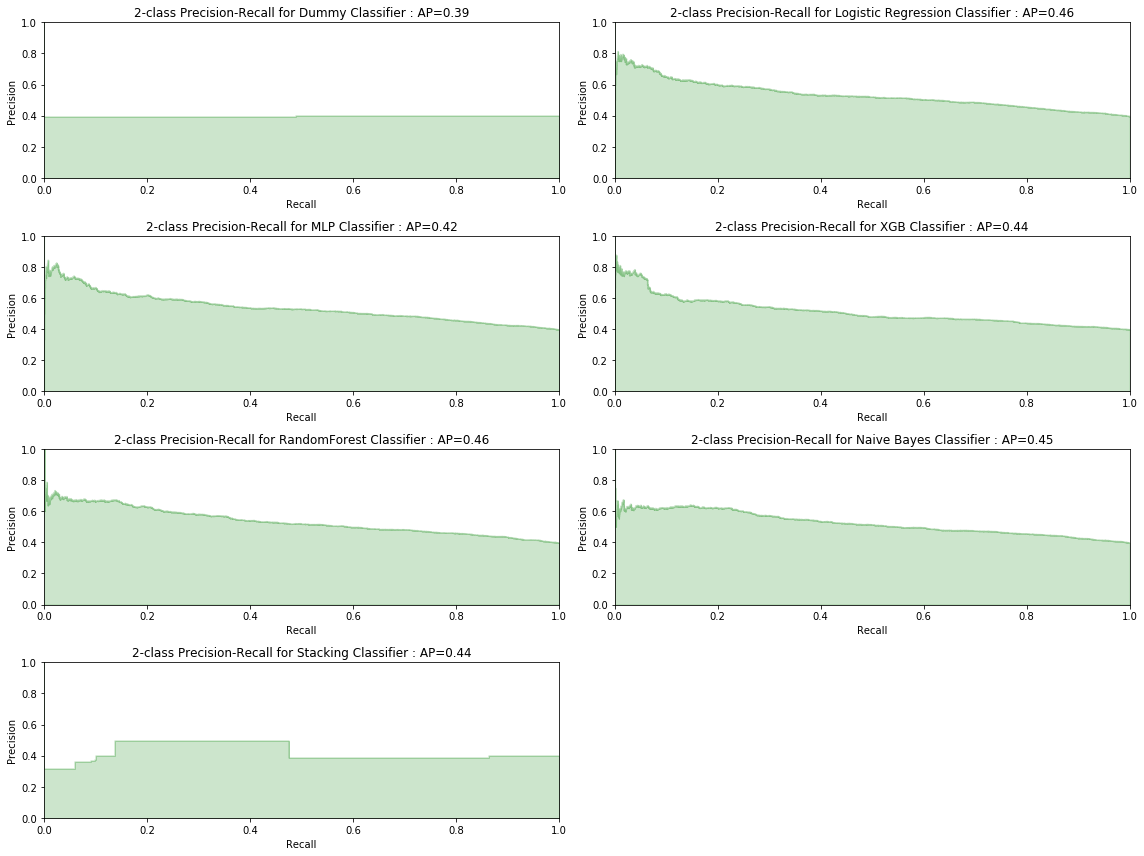

In [60]:
# Plotting the precision-recall curves for the different classifiers

plt.figure(figsize=(16,12))

plt.subplot(4,2,1)
precision_recall(y_test['readmitted_p'], y_pred0, dm.predict_proba(X_test)[:,1], 'Dummy')
plt.subplot(4,2,2)
precision_recall(y_test['readmitted_p'], y_pred1, lr_best.predict_proba(X_test)[:,1], 'Logistic Regression')
plt.subplot(4,2,3)
precision_recall(y_test['readmitted_p'], y_pred2, mlp2.predict_proba(X_test)[:,1], 'MLP')
plt.subplot(4,2,4)
precision_recall(y_test['readmitted_p'], y_pred3, xgb_best.predict_proba(X_test_n)[:,1], 'XGB')
plt.subplot(4,2,5)
precision_recall(y_test['readmitted_p'], y_pred4, rf_best.predict_proba(X_test_n)[:,1], 'RandomForest')
plt.subplot(4,2,6)
precision_recall(y_test['readmitted_p'], NB['y_label'], NB['class_1'], 'Naive Bayes')
plt.subplot(4,2,7)
precision_recall(y_test['readmitted_p'], y_pred6, sclf.predict_proba(X_test)[:,1], 'Stacking')
plt.tight_layout()

Based on the confusion matrix, classification report and the plots above, the best performing classifier on the test set is MLP followed by Logistic Regression. Since MLP Classifier is based on Neural Networks, it is not possible to find the coefficients of the features and hence it is not possible to find out which features contribute the most to the predictions of the readmission outcome. Hence, we will get the coefficients of the features based on the 2nd best model Logistic Regression. However, it should be noted that different models do give different coefficients for the features, and hence that given by the Logistic Regression may not reflect the true importance of features for the MLP Classifer.

In [94]:
# Finding out the coefficients of the features, aka feature importance from Logistic Regression
pd.set_option('display.max_rows', None)
lr_coefs = pd.DataFrame(data={'Features':X_ros.columns, 'Coefficients':lr_best.coef_[0], 'Abs_Coefficients':np.abs(lr_best.coef_[0])})
lr_coefs.sort_values(by='Abs_Coefficients', ascending=False)

,Abs_Coefficients,Coefficients,Features
27,5.325794,5.325794,number_inpatient
25,3.444310,3.444310,number_outpatient
26,3.377738,3.377738,number_emergency
37,1.759174,1.759174,age_4
38,1.605210,-1.605210,admission_type_id_1
42,1.353234,1.353234,admission_type_id_5
35,1.319191,1.319191,age_2
14,1.280592,-1.280592,tolazamide
36,1.267788,1.267788,age_3
50,1.263153,-1.263153,admission_source_id_2


In [97]:
# The top 10 most important features based on Logistic Regression
lr_coefs.sort_values(by='Abs_Coefficients', ascending=False)['Features'][:10]

27         number_inpatient
25        number_outpatient
26         number_emergency
37                    age_4
38      admission_type_id_1
42      admission_type_id_5
35                    age_2
14               tolazamide
36                    age_3
50    admission_source_id_2
Name: Features, dtype: object

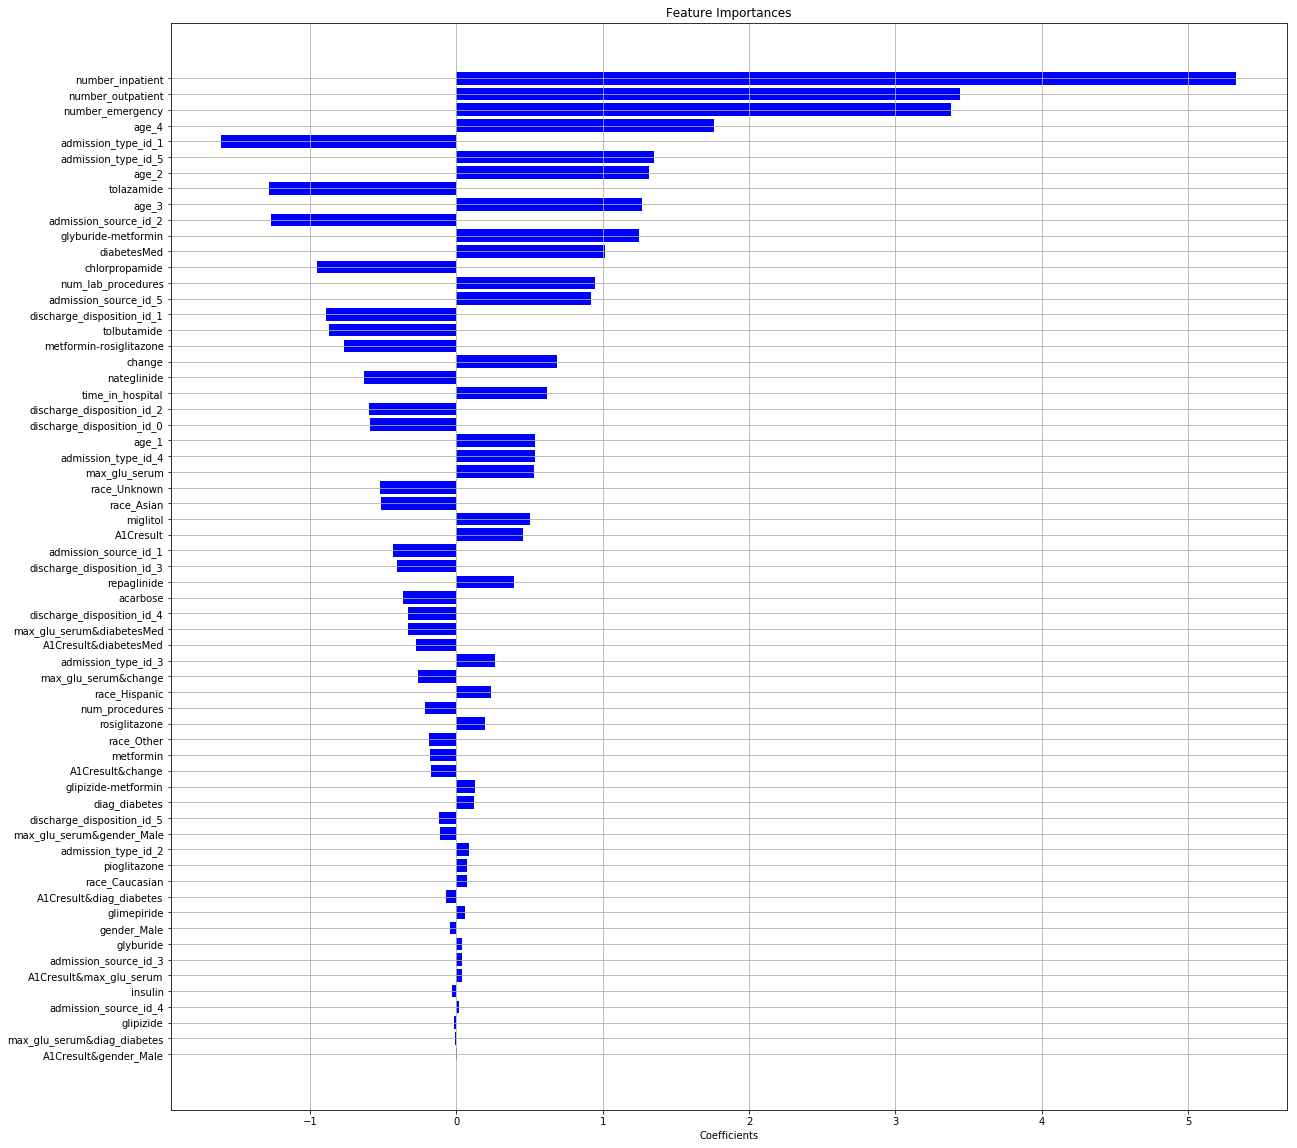

In [126]:
features = lr_coefs.sort_values(by='Abs_Coefficients', ascending=True)['Features']
coefficients = lr_coefs.sort_values(by='Abs_Coefficients', ascending=True)['Coefficients']
indices = np.array(coefficients)

plt.figure(figsize=(20,20))
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), coefficients, color='b', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Coefficients')
plt.grid(True)